<img src="http://drive.google.com/uc?export=view&id=1tpOCamr9aWz817atPnyXus8w5gJ3mIts" width=500px>

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Spam SMS Classification

## Domain
SMS, Text Data

## Business Context
The SMS spam is a growing problem considering availability of cheap sms packages offered by various telecom service companies. SMS spam filtering is a relatively new task which inherits many issues and solutions from email spam filtering. The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged according to ham (legitimate) or spam.
 
## Objective
Given a text message and label whether a sms is a spam message, can you train a classification model that allows you to correctly predict a new sms as spam or ham. 



### Package version
- tensorflow==2.3.0
- matplotlib==3.2.1
- h5py==2.10.0
- google==2.0.3

## Table of Content

1. Import Libraries

2. Setting options

3. Read Data

4. Data Analysis and Preparation

5. Text Preprocessing

6. Model Building

7. Conclusion and Interpretation

## 1. Import Libraries

Let us start by mounting the drive

In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let us check for the version of installed tensorflow.

In [158]:
# used to supress display of warnings
import warnings

# os is used to provide a way of using operating system dependent functionality
# We use it for setting working folder
import os

# Pandas is used for data manipulation and analysis
import pandas as pd 

# Numpy is used for large, multi-dimensional arrays and matrices, along with mathematical operators on these arrays
import numpy as np

# Matplotlib is a data visualization library for 2D plots of arrays, built on NumPy arrays 
# and designed to work with the broader SciPy stack
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

# Seaborn is based on matplotlib, which aids in drawing attractive and informative statistical graphics.
import seaborn as sns
import tensorflow 
print(tensorflow.__version__)


from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

2.8.0


## 2. Setting Options

In [159]:
# suppress display of warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# display all dataframe rows
pd.options.display.max_rows = None

## 3. Read Data
### 3.1 Read the data from the provided csv sms_spam_data.csv

In [160]:
path  = "/content/drive/MyDrive/Colab Notebooks/Great learning/Statistical NLP/Assignment/spam.csv"

In [161]:
file = open(path, 'r', encoding="ISO-8859-1")


In [162]:
data = pd.read_csv(file)

### 3.2 Check info and shape of the data

In [163]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [165]:
data.shape

(5572, 5)

### 3.3 Drop irrelevant columns

In [166]:
data.columns
labels = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

In [167]:
df1 = data.copy()
df1.drop(labels, inplace = True, axis = 1)

In [168]:
df1.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 4. Data Analysis and Preparation

### 4.1 Check frequency distribution of target column. Report whether the class is balanced or not?

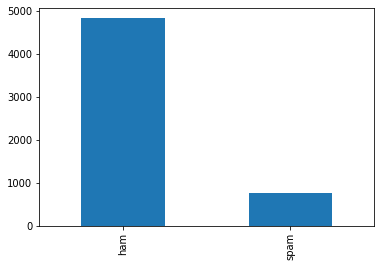

In [169]:
fig, ax = plt.subplots()
df1['v1'].value_counts().plot(ax=ax, kind='bar')

# The data is highly imbalanced and there are more class for ham.

### 4.2 Encode the label column and make it numerical

In [170]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df1['v1'] = le.fit_transform(df1['v1'])

In [171]:
df1.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [172]:
df1.rename({"v1" : "Labels", "v2" : "Message"}, inplace = True, axis = 1)

In [173]:
df1.head()

,Labels,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## 5. Text Preprocessing

### 5.1 Create a new column having length of the text message and see it’s distribution for the two classes ( ham and spam) and comment your findings

In [174]:
df1["Length"] = df1["Message"].apply(lambda x:len(x))

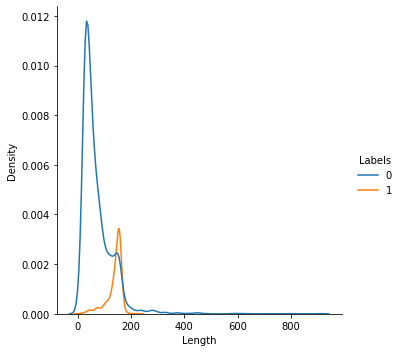

In [175]:
import seaborn as sns
sns.displot(data=df1, x='Length', hue='Labels', kind='kde')
# The density of spam messages are less but the length of spam text is more.

### 5.2 Preprocess the text data to make it suitable for model building
- Convert the text message into lower case letters

In [176]:
df1["lower_message"] = df1["Message"].str.lower()

- Remove stop words from the text message

In [177]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [178]:
df1['lower_message'] = df1['lower_message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


- Remove punctuations

In [179]:
df1['lower_message'] = df1['lower_message'].str.replace('[^\w\s]', '')

### 5.3 Segregate the data into X (independent feature - text message) and y (label) and split the data into train and test set ( take test size = 0.30)

In [180]:
X = df1["lower_message"]
y = df1["Labels"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### 5.4 Create feature vectors of the text data

In [181]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X_train_transform = vect.fit_transform(X_train)
X_test_transform = vect.transform(X_test)

## 6. Model building

### 6.1 Build and evaluate the Naive Bayes Model

In [182]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_transform, y_train)

MultinomialNB()

### 6.2 Predict label for the test data and check confusion matrix

In [183]:
pred = clf.predict(X_test_transform)

In [184]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, pred)

0.979066985645933

In [185]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1453
           1       0.96      0.88      0.92       219

    accuracy                           0.98      1672
   macro avg       0.97      0.94      0.95      1672
weighted avg       0.98      0.98      0.98      1672



In [186]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[1444,    9],
       [  26,  193]])

# 7. Conclusion and Interpretation


In [187]:
# The model's accuracy is good but in this case, the recall for spam is less which should be improved.
# But the recall of ham messages is predicted well by the model. Overall performance of the model is good.
# Overall the macroaverage of the scores are good and for weighted average the contribution of the each 
# class is good. 

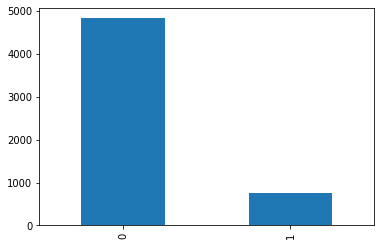

In [188]:
fig, ax = plt.subplots()
y.value_counts().plot(ax=ax, kind='bar')

##. Further Explore

- Can you analyze the false positive and false negative messages individually and figure out why the model made a mistake and how it can be improved?

In [189]:
temp = pd.DataFrame({"Message" : X_test, "Y_Actual" : y_test, "Predicted" : pred}, columns = ["Message", "Y_Actual", "Predicted"])

In [190]:
temp1 = temp[temp['Y_Actual'] != temp['Predicted']]

In [191]:
temp1.sort_values(by=['Y_Actual'])

,Message,Y_Actual,Predicted
4700,liked new mobile,0,1
1505,total video converter free download type googl...,0,1
1024,pattern recently crap weekends,0,1
4701,anytime,0,1
4417,get free call,0,1
3326,number u live at 11,0,1
2418,madamregret disturbancemight receive reference...,0,1
75,waiting machan call free,0,1
5044,sent jd customer service cum accounts executiv...,0,1
683,hi im sue 20 years old work lapdancer love sex...,1,0


In [192]:
# The model predicting ham as spam is because of words like mobile numbers, download, internet terms, free. So in
# training dataset the model would have seen these words as spam. So this can be solved by 
# either changing the sample size or by using DL or other things like Tf-IDF or pretrained model.

# In terms of predicting spam as ham the messages are like conversation between humans. So in training dataset 
# the model would have got more ham messages which are like conversation between humans. So this can be 
# solved by using DL or other things like Tf-IDF or pretrained model or creating function that categorises these
# dialogues as sexual dialogues and train the model based on this.



